In [126]:
import numpy as np
from neuralop.models import UNO
import matplotlib.pyplot as plt
import torch.nn.functional as F
import pickle as pk
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from utils.visualizations import *
import torch

In [127]:
train_data_loc = '/home/arunreddy/ML/Social-Robots/Human_Motion_Refine (1)/data/data_more_processing/normalized_axis_magnitude_train_data_new.npy'
train_data = np.load(train_data_loc, allow_pickle=True)

In [128]:
type(train_data), train_data.shape

(numpy.ndarray, (994, 2, 300, 242))

In [129]:
datapoint = 56

In [130]:
source = train_data[datapoint][0]
target = train_data[datapoint][1]

In [131]:
source.shape, target.shape

((300, 242), (300, 242))

In [132]:
source_torch = torch.tensor(source).unsqueeze(0).permute(0, 2, 1).float()
target_torch = torch.tensor(target).unsqueeze(0).permute(0, 2, 1).float()

In [133]:
source_torch = source_torch.reshape(1, -1)
target_torch = target_torch.reshape(1, -1)

In [134]:
class MLP(nn.Module):
    def __init__(self, input_dim=72600, hidden_dim=512, output_dim=72600, num_hidden_layers=3):
        super(MLP, self).__init__()
        layers = []

        # Input layer
        layers.append(nn.Linear(input_dim, hidden_dim))
        layers.append(nn.ReLU())

        # Hidden layers
        for _ in range(num_hidden_layers - 1):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.ReLU())

        # Output layer
        layers.append(nn.Linear(hidden_dim, output_dim))

        # Register the model as a Sequential module
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [135]:
mlp_model = MLP(hidden_dim=530, num_hidden_layers=10)

In [136]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters())

In [137]:
output_torch = mlp_model(source_torch)

In [138]:
output_torch.shape

torch.Size([1, 72600])

In [139]:
F.mse_loss(output_torch, target_torch)

tensor(0.0284, grad_fn=<MseLossBackward0>)

In [140]:
loss_vals = []

In [141]:
criterion = nn.MSELoss()  # Mean Squared Error for regression
optimizer = optim.Adam(mlp_model.parameters(), lr=1e-4)  # Stochastic Gradient Descent
num_epochs = 100

In [142]:
for epoch in tqdm(range(num_epochs)):
    optimizer.zero_grad()
    output_torch = mlp_model(source_torch)
    loss = criterion(output_torch, target_torch)
    loss.backward()
    optimizer.step()
    loss_vals.append(loss.item())
    if epoch % 10 == 0:  # Print every 10 epochs
        print(f"Epoch {epoch}, Loss: {loss.item()}")

  1%|          | 1/100 [00:00<00:59,  1.66it/s]

Epoch 0, Loss: 0.028440700843930244


 11%|█         | 11/100 [00:05<00:44,  2.02it/s]

Epoch 10, Loss: 0.026448611170053482


 21%|██        | 21/100 [00:10<00:38,  2.07it/s]

Epoch 20, Loss: 0.021939095109701157


 31%|███       | 31/100 [00:15<00:32,  2.13it/s]

Epoch 30, Loss: 0.010183683596551418


 41%|████      | 41/100 [00:20<00:30,  1.91it/s]

Epoch 40, Loss: 0.004494230728596449


 51%|█████     | 51/100 [00:25<00:24,  2.01it/s]

Epoch 50, Loss: 0.0018348534358665347


 61%|██████    | 61/100 [00:30<00:18,  2.13it/s]

Epoch 60, Loss: 0.0007983686518855393


 71%|███████   | 71/100 [00:34<00:13,  2.14it/s]

Epoch 70, Loss: 0.0003430314245633781


 81%|████████  | 81/100 [00:39<00:08,  2.14it/s]

Epoch 80, Loss: 0.00014421511150430888


 91%|█████████ | 91/100 [00:44<00:04,  2.12it/s]

Epoch 90, Loss: 6.154695438453928e-05


100%|██████████| 100/100 [00:48<00:00,  2.06it/s]


In [143]:
loss_vals[0]

0.028440700843930244

In [144]:
loss_vals[-1]

2.7921762011828832e-05

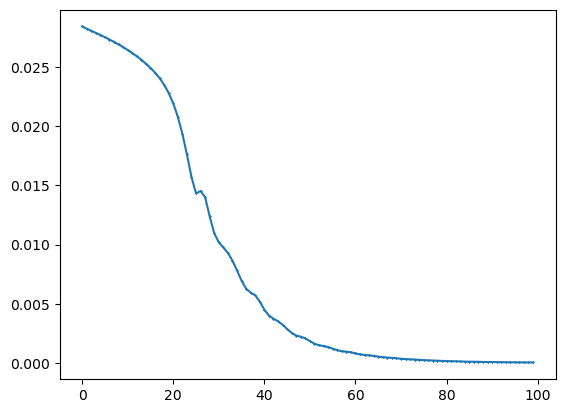

In [145]:
plt.plot(loss_vals, marker = 'x', markersize=1, markerfacecolor = 'r')

In [146]:
(np.sqrt(loss_vals[0])/(abs(target_torch).mean()))*100

tensor(126.0025)

In [147]:
(np.sqrt(loss_vals[-1])/(abs(target_torch).mean()))*100

tensor(3.9480)

In [148]:
source_torch.shape, target_torch.shape, output_torch.shape

(torch.Size([1, 72600]), torch.Size([1, 72600]), torch.Size([1, 72600]))

In [149]:
source_torch = source_torch.reshape(-1, 242, 300)
target_torch = target_torch.reshape(-1, 242, 300)
output_torch = output_torch.reshape(-1, 242, 300)

In [150]:
def denormalize_global(array, min_val=-5.049882127052023, max_val=6.446737822522641):
    if max_val == min_val:
        return np.zeros_like(array)
    return (array + 1) * (max_val - min_val) / 2 + min_val

In [151]:
def convert_to_axis_angle(data):
    '''data [T, 242]'''
    axis_magnitude = data[:, 6:226].reshape(-1, 55, 4)
    axis = axis_magnitude[:, :, :3]
    magnitude = axis_magnitude[:, :, 3:]
    poses = axis * (magnitude+1e-10)
    poses = poses.reshape(axis_magnitude.shape[0], -1)
    new_data = torch.cat([data[:, :6], poses, data[:, 226:]], axis=1)
    return new_data

In [152]:
source_un_norm = denormalize_global(source_torch.permute(0, 2, 1))
source_un_norm_axis_angle = torch.stack([convert_to_axis_angle(point) for point in source_un_norm])

In [153]:
target_un_norm = denormalize_global(target_torch.permute(0, 2, 1))
target_un_norm_axis_angle = torch.stack([convert_to_axis_angle(point) for point in target_un_norm])

In [154]:
output_un_norm = denormalize_global(output_torch.permute(0, 2, 1))
output_un_norm_axis_angle = torch.stack([convert_to_axis_angle(point) for point in output_un_norm])

In [155]:
source_un_norm_axis_angle.shape, target_un_norm_axis_angle.shape, output_un_norm_axis_angle.shape

(torch.Size([1, 300, 187]),
 torch.Size([1, 300, 187]),
 torch.Size([1, 300, 187]))

In [156]:
path = '/home/arunreddy/ML/Social-Robots/Code/Duolando-main/animations_test/'

In [157]:
vis_results(source_un_norm_axis_angle, target_un_norm_axis_angle, output_un_norm_axis_angle, 1, path, is_smplx=True)

Plotting at epoch 1


100%|██████████| 1/1 [03:29<00:00, 209.50s/it]


In [158]:
abs(output_un_norm_axis_angle[0][100] - output_un_norm_axis_angle[0][1]).mean()

tensor(0.1779, grad_fn=<MeanBackward0>)

In [159]:
abs(target_un_norm_axis_angle[0][100] - target_un_norm_axis_angle[0][1]).mean()

tensor(0.1732)

##### The current model will not work at all, if you use sgd. But will work magically if you use Adam, maybe this was the problem with the previous fno_model_new.ipynb